In [7]:
# System
import os
import sys
import inspect

# Data processing
import numpy as np
import math as m

# Results presentation
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from IPython.display import clear_output
from tabulate import tabulate

# NN related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# from torch.autograd import Variable

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import data
import models
import utils
import correlation

%matplotlib inline

In [8]:
class GlobalArguments():
    
    def __init__(self):
        self.model       = 'vgg16_bn'
        self.dataset     = 'CIFAR100'
        self.data_path   = '../Data/'
        self.batch_size  = 128
        self.num_workers = 4
        self.transform   = 'VGG'
        self.use_test    = True
        self.models_path = '../Checkpoints/FGE/CIFAR100/VGG16BN/common/0/'
        self.n_models    = 17
args = GlobalArguments()

In [9]:
loaders, num_classes = data.loaders(
    args.dataset,
    args.data_path,
    args.batch_size,
    args.num_workers,
    args.transform,
    args.use_test
)

Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


In [10]:
architecture = getattr(models, args.model)

In [37]:
models_list_fge = []
# indicies = range (690, 1011, 20)
indicies = [i for i in range (219, 340, 20)]
indicies.insert(0, 200)

for i in tqdm(indicies):
    model = architecture.base(num_classes=num_classes, **architecture.kwargs)
    checkpoint = torch.load(args.models_path + 'fge-' + str(i) + '.pt', map_location=torch.device('cpu'))
#     print (model)
    model.load_state_dict(checkpoint['model_state'])
    models_list_fge.append(model)

100%|██████████| 8/8 [00:51<00:00,  6.50s/it]


In [38]:
# models_list_ind = []
# indicies = [i for i in range (8)]

# for i in tqdm(indicies):
#     model = architecture.base(num_classes=num_classes, **architecture.kwargs)
#     checkpoint = torch.load('../Checkpoints/VGG16BN/CIFAR100_STEP200/' + str(i) + '/checkpoint-200.pt', map_location=torch.device('cpu'))
# #     print (model)
#     model.load_state_dict(checkpoint['model_state'])
#     models_list_ind.append(model)

In [46]:
models_list_frw = []
# indicies = range (690, 1011, 20)
indicies = [i for i in range (40, 281, 40)]
# indicies.insert(0, 200)

for i in tqdm(indicies):
    model = architecture.base(num_classes=num_classes, **architecture.kwargs)
    checkpoint = torch.load('../Checkpoints/VGG16BN/CIFAR100_STEP280/0/checkpoint-' + str(i) + '.pt', map_location=torch.device('cpu'))
#     print (model)
    model.load_state_dict(checkpoint['model_state'])
    models_list_frw.append(model)

100%|██████████| 7/7 [00:23<00:00,  3.39s/it]


In [17]:
# model1 = architecture.base(num_classes=num_classes, **architecture.kwargs)
# checkpoint = torch.load('./Checkpoints/VGG16BN/new/CIFAR10_STEP200/2/checkpoint-' + str(200) + '.pt', map_location=torch.device('cpu'))
# model1.load_state_dict(checkpoint['model_state'])

# model2 = architecture.base(num_classes=num_classes, **architecture.kwargs)
# checkpoint = torch.load('./Checkpoints/VGG16BN/new/CIFAR10_STEP200/3/checkpoint-' + str(200) + '.pt', map_location=torch.device('cpu'))
# model2.load_state_dict(checkpoint['model_state'])

In [18]:
# table = correlation.layers_diff(model1, model2)

In [19]:
# for a in table:
#     print (a)

In [20]:
# print(tabulate(table, headers='keys'))

In [21]:
# for p in model.modules():
#     print (type(p))
#     for a in p.state_dict().keys():
#         print ('    ', a, p.state_dict()[a].shape)

# for idx, module in enumerate(model.modules()):
#     if type(module) == torch.nn.modules.conv.Conv2d:
#         for key in module.state_dict().keys():
#             print ('[', idx, ']', key, module.state_dict()[key].shape)


In [22]:
# a = correlation.correlation_over_classes(model1, model2, loaders['test'], torch.device('cuda:0'))

In [23]:
# correlation.layers_L2(models_list_fge[0], models_list[1], device=torch.device('cuda:0'))

In [24]:
# cor_matrix = correlation.cross_entropy_Nmodels (models_list_fge, loaders['test'], torch.device('cpu'), mean=True)

In [27]:
# cor_matrix_ind = correlation.correlation_Nmodels (models_list_ind, loaders['test'], torch.device('cuda:0'), one_hot=False)

8it [00:24,  3.09s/it]


In [40]:
# cor_matrix_fge = correlation.correlation_Nmodels (models_list_fge, loaders['test'], torch.device('cuda:0'))

8it [00:22,  2.82s/it]


In [47]:
cor_matrix_frw = correlation.correlation_Nmodels (models_list_frw, loaders['test'], torch.device('cuda:0'))

7it [00:18,  2.65s/it]


In [25]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [26]:
# models_num = [i+1 for i in range(len(cor_matrix))]
# fig, ax = plt.subplots()

# im, cbar = heatmap(cor_matrix, models_num, models_num, ax=ax,
#                    cmap="YlGn", cbarlabel="corelation")
# texts = annotate_heatmap(im, valfmt="{x:.3f}")

# fig.tight_layout()
# plt.show()

In [28]:
# models_num = [i+1 for i in range(len(cor_matrix))]
# fig, ax = plt.subplots()

# im, cbar = heatmap(cor_matrix, models_num, models_num, ax=ax,
#                    cmap="YlGn", cbarlabel="correlation")
# texts = annotate_heatmap(im, valfmt="{x:.3f}")

# fig.tight_layout()
# plt.show()

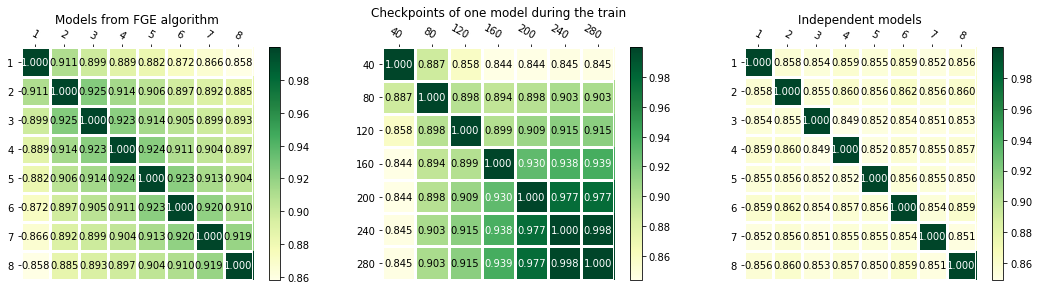

In [49]:
models_num_ind = [i+1 for i in range(len(cor_matrix_ind))]
models_num_fge = [i+1 for i in range(len(cor_matrix_fge))]
models_num_frw = [i for i in range(40, 281, 40)]

fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=1, ncols=3,
    figsize=(15, 4))

ax1.set_title('Models from FGE algorithm')
im1, cbar1 = heatmap(cor_matrix_fge, models_num_fge, models_num_fge, ax=ax1,
                   cmap="YlGn")
texts1 = annotate_heatmap(im1, valfmt="{x:.3f}")

ax2.set_title('Checkpoints of one model during the train')
im2, cbar2 = heatmap(cor_matrix_frw, models_num_frw, models_num_frw, ax=ax2,
                   cmap="YlGn")
texts2 = annotate_heatmap(im2, valfmt="{x:.3f}")

ax3.set_title('Independent models')
im3, cbar3 = heatmap(cor_matrix_ind, models_num_ind, models_num_ind, ax=ax3,
                   cmap="YlGn")
texts3 = annotate_heatmap(im3, valfmt="{x:.3f}")

fig.tight_layout()
plt.savefig('figures/correlations.png', dpi=400)
plt.show()